# Predict with pre-trained models

This is a demo for predicting with a pre-trained model on the full imagenet dataset, which contains over 10 million images and 10 thousands classes. For a more detailed explanation, please refer to [predict.ipynb](https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb).

We first load the pre-trained model.

In [1]:
import os, urllib
import mxnet as mx
def download(url,prefix=''):
    filename = prefix+url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)

path='http://data.mxnet.io/models/imagenet-11k/'
download(path+'resnet-152/resnet-152-symbol.json', 'full-')
download(path+'resnet-152/resnet-152-0000.params', 'full-')
download(path+'synset.txt', 'full-')

with open('full-synset.txt', 'r') as f:
    synsets = [l.rstrip() for l in f]

sym, arg_params, aux_params = mx.model.load_checkpoint('full-resnet-152', 0)

Create a model for this model on GPU 0.

In [2]:
mod = mx.mod.Module(symbol=sym, context=mx.gpu())
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
mod.set_params(arg_params, aux_params)

Next we define the function to obtain an image by a given URL and the function for predicting.

In [3]:
%matplotlib inline
import matplotlib
matplotlib.rc("savefig", dpi=100)
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=True):
    filename = url.split("/")[-1]
    urllib.urlretrieve(url, filename)
    img = cv2.imread(filename)
    if img is None:
        print('failed to download ' + url)
    if show:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    return filename

def predict(filename, mod, synsets):
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    if img is None:
        return None
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 
    
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)

    a = np.argsort(prob)[::-1]    
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], synsets[i]))
    

We are able to classify an image and output the top predicted classes. 

probability=0.692314, class=n02122948 kitten, kitty
probability=0.043846, class=n01323155 kit
probability=0.030001, class=n01318894 pet
probability=0.029692, class=n02122878 tabby, queen
probability=0.026972, class=n01322221 baby


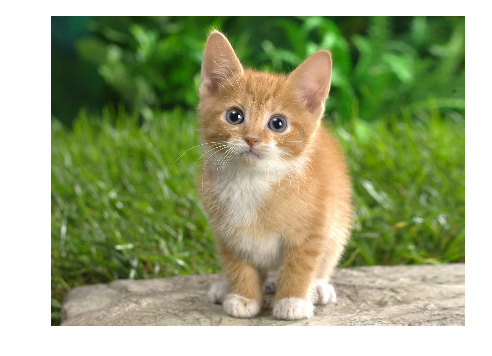

In [4]:
url = 'http://writm.com/wp-content/uploads/2016/08/Cat-hd-wallpapers.jpg'
predict(get_image(url), mod, synsets)

probability=0.569505, class=n02088364 beagle
probability=0.052795, class=n00452864 beagling
probability=0.039277, class=n02778669 ball
probability=0.017777, class=n02087122 hunting dog
probability=0.016321, class=n10611613 sleuth, sleuthhound


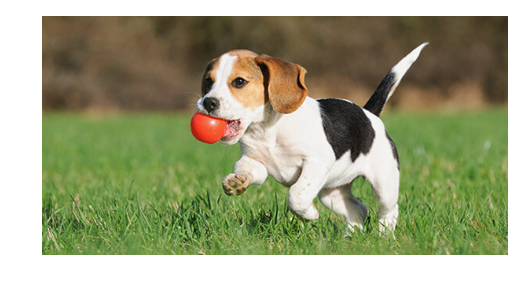

In [5]:
url = 'https://images-na.ssl-images-amazon.com/images/G/01/img15/pet-products/small-tiles/23695_pets_vertical_store_dogs_small_tile_8._CB312176604_.jpg'
predict(get_image(url), mod, synsets)